# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.de

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [1]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from func.api import Benchmark

In [2]:

import os as os
print(os.getcwd())
bench_dir = "cached/fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)


c:\Users\saipr\Documents\Deep Learning\ws19\LCBench_DL
==&gt; Loading data...
==&gt; No cached data found or cache set to False.
==&gt; Reading json data...
==&gt; Done.


In [3]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [ ]:
# Config
print("Config example:", train_data[0]["config"])
#print(len(val_data[0]["Train/loss"]))
print(len(val_data[0]["Train/gradient_norm"]))

#print("train targets")
print(train_targets)
#print("Config example:", train_data[1]["config"])
print(train_data[0]["Train/layer_wise_gradient_std_layer_2"][-1])

## Our implementation

In [4]:
from sklearn import preprocessing

def scale_features(X, method=None,direction=None):
    '''This function is used perform feature scaling. 
        Have implemented 2 methods: min-max normalization, 
        Z-normalization'''
    if method == "znorm":
        scaler = preprocessing.StandardScaler()
        if direction == "v":
            x_std = scaler.fit_transform(X)
            return x_std
        else:
            x_std = scaler.fit_transform(X.T)
            return x_std.T
    elif method == "minmax":
        min_max_scaler = preprocessing.MinMaxScaler()
        if direction == "v":
            x_minmax = min_max_scaler.fit_transform(X)
            return x_minmax
        else:
            x_minmax = min_max_scaler.fit_transform(X.T)
            return x_minmax.T


In [5]:
def get_specific_inputs(input_data):
    N = len(input_data)
    config_features = np.zeros((N, 7))
    val_accuracy_till_nepoch = np.zeros((N, 50))

    for i in range(N):
        config_features[i][0] = train_data[i]["config"]["batch_size"]
        config_features[i][1] = train_data[i]["config"]["max_dropout"]
        config_features[i][2] = train_data[i]["config"]["max_units"]
        config_features[i][3] = train_data[i]["config"]["num_layers"]
        config_features[i][4] = train_data[i]["config"]["learning_rate"]
        config_features[i][5] = train_data[i]["config"]["momentum"]
        config_features[i][6] = train_data[i]["config"]["weight_decay"]
        val_accuracy_till_nepoch[i] = train_data[i]["Train/val_accuracy"][:-1]
    
    config_features = scale_features(config_features, method="minmax",direction="v")
    val_accuracy_till_nepoch = scale_features(val_accuracy_till_nepoch, method="minmax")
    print("val acc shape", val_accuracy_till_nepoch.shape)
    print("config_features shape", config_features.shape)
    return(np.concatenate((config_features, val_accuracy_till_nepoch), axis=1))

In [6]:
# do scaling here 

#print(train_data[0]["Train/val_accuracy"])
#print(train_targets[0])
#print()
#print(val_data[0]["Train/val_accuracy"])
#print(val_targets[0])


tr_data= get_specific_inputs(train_data)
print(tr_data[0])
print(tr_data.shape)
new_tr_labels = scale_features(np.concatenate((tr_data, np.c_[train_targets]), axis=1), method="minmax")
tr_data = new_tr_labels[:, :-1] # for all but last column
tr_labels = new_tr_labels[:, -1] # for last column
#print(tr_data.shape)
print(tr_data[0])
#print(tr_labels.shape)
#print(tr_labels[0])

#print(vl_data[0])
vl_data= get_specific_inputs(val_data)
new_vl_labels = scale_features(np.concatenate((vl_data, np.c_[val_targets]), axis=1), method="minmax")
vl_data = new_vl_labels[:, :-1] # for all but last column
vl_labels = new_vl_labels[:, -1] # for last column
#print(vl_data.shape)
print(vl_data[0])
#print(vl_labels.shape)
#print(vl_labels[0])

tst_data = get_specific_inputs(test_data)
tst_labels= np.c_[test_targets]

#print(tst_data.shape)
#print(tst_data[0])
#print(tst_labels.shape)
#print(tst_labels[0])


val acc shape (1000, 50)
config_features shape (1000, 7)
[0.11133603 0.02540542 0.23854167 0.66666667 0.01763205 0.12829871
 0.20437858 0.         0.7056058  0.80707827 0.85914488 0.87803798
 0.89409264 0.90668793 0.9180415  0.92983854 0.93844238 0.94864292
 0.9532553  0.95999649 0.96336702 0.97046297 0.97108389 0.97711544
 0.98013132 0.98261489 0.98545323 0.98571938 0.98722727 0.99104129
 0.99104129 0.99396845 0.99414578 0.99441194 0.99387974 0.99503286
 0.99627459 0.99769376 0.99760515 0.99742771 0.99831468 0.99778248
 0.99795991 1.         0.99991128 0.99911303 0.9994678  0.9989356
 0.99911303 0.99920175 0.99973385 0.9994678  0.99955652 0.99955652
 0.9994678  0.9994678  0.9994678 ]
(1000, 57)
[0.00133163 0.00030386 0.00285306 0.00797362 0.00021089 0.00153451
 0.00244446 0.         0.00843935 0.00965301 0.01027575 0.01050172
 0.01069374 0.01084438 0.01098018 0.01112127 0.01122418 0.01134618
 0.01140135 0.01148198 0.01152229 0.01160716 0.01161459 0.01168673
 0.0117228  0.0117525  0.01

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import numpy as np
import time
import json
from torch.autograd import Variable
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

# network hyperparameters
BATCH_SIZE = 4
EPOCHS = 70

train_data = TensorDataset(torch.from_numpy(tr_data).float(), torch.from_numpy(tr_labels).float())
val_data = TensorDataset(torch.from_numpy(vl_data).float(), torch.from_numpy(vl_labels).float())
test_data = TensorDataset(torch.from_numpy(tst_data).float(), torch.from_numpy(tst_labels).float())

#print(type(train_data))
#print(train_data[0])

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE,num_workers=2)
val_loader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE,num_workers=2)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE,num_workers=2)

In [12]:
class CNN_LSTM(nn.Module):
    """
    A two layer CNN used to extract configuration features which are further used 
    to initalize the initial hidden state of the 3 Layer LSTM network, followed
    by two fully connected layer to the output.
    
    Net Architecture:
        CNN_LSTM(
        (pool): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
        (relu): ReLU()
        (drop): Dropout(p=0.4, inplace=False)
        (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv2): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (lstm): LSTM(1, 64, num_layers=3)
        (fc1): Linear(in_features=3200, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=1, bias=True)
    """
    def __init__(self, INPUT_SIZE=50, HIDDEN_SIZE=64, OUTPUT_SIZE=1):
        super(CNN_LSTM, self).__init__()
        
        self.pool = nn.MaxPool1d(3, stride=1)
        self.relu = nn.ReLU()
        self.n_layers=3
        self.drop = nn.Dropout(p=0.5)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=self.n_layers)
        self.hidden_state = torch.randn(self.n_layers, BATCH_SIZE, HIDDEN_SIZE)
        self.cell_state = torch.randn(self.n_layers, BATCH_SIZE, HIDDEN_SIZE)
        self.hidden = (self.hidden_state, self.cell_state)
        
        self.fc1 = nn.Linear(50*HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)


    def forward(self, input_lstm, config_features):
        """
        Forward pass for the network.
        Args:
            input_lstm : the Train/val_accuracy time series Batch_Size*50.
            config_features : a vector of 7 variable features across run 
                              configurations as input to the CNN.
        """
        config_features = self.pool(self.relu(self.conv1(config_features)))
        config_features = self.pool(self.relu(self.conv2(config_features)))

        self.hidden_state = config_features.reshape(self.n_layers, BATCH_SIZE, 64)
        out, (hn, cn) = self.lstm(input_lstm.reshape(50 ,BATCH_SIZE, 1), self.hidden)
        out = out.view(BATCH_SIZE, -1)

        out = self.relu(self.fc1(out))
        out = self.drop(out)
        out = self.fc2(out)

        return out.view(-1)

In [13]:
class standard_LSTM(nn.Module):
    """
    standard_LSTM
    A simple one layer standard LSTM module followed by 2 fully connected layer.
    
    Net Architecture:
        standard_LSTM(
        (relu): ReLU()
        (lstm): LSTM(1, 100)
        (drop): Dropout(p=0.3, inplace=False)
        (fc1): Linear(in_features=5700, out_features=100, bias=True)
        (fc2): Linear(in_features=100, out_features=1, bias=True)
        )
    """
    def __init__(self, INPUT_SIZE=57, HIDDEN_SIZE=100, OUTPUT_SIZE=1):
        super(standard_LSTM, self).__init__()
        self.relu = nn.ReLU()
        self.input_dim=HIDDEN_SIZE
        self.n_layers=1
    
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=self.n_layers)
        
        self.hidden_state = torch.zeros(self.n_layers, BATCH_SIZE, HIDDEN_SIZE)
        self.cell_state = torch.zeros(self.n_layers, BATCH_SIZE, HIDDEN_SIZE)
        self.hidden = (self.hidden_state, self.cell_state)
        
        self.drop = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(57*HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)


    def forward(self, x):
        """
        Forward pass for the network.
        Args:
            x : a vector of 7 hyperparamter features aprepended to 
            the 50 step Train/val_accuracy time series.
        """
        lstm_input = x.reshape(57,BATCH_SIZE, 1)
        out, (hn, cn) = self.lstm(lstm_input, self.hidden)

        out = out.view(BATCH_SIZE, -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out.view(-1)

In [14]:
# toggle to debug
#torch.autograd.set_detect_anomaly(True)
    
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model1 = CNN_LSTM()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss_fn = nn.MSELoss()
print(model1)

# train model1 and log train/validation losses
CNN_LSTM_train_losses = []
CNN_LSTM_validation_losses = []

#different train-validation loop for CNN_LSTM since we split the data to feed CNN and LSTM
for epoch in range(EPOCHS):
    batch_losses = []
    training_loss = 0.0
    #training loop
    for inputs, labels in train_loader:
        #print(inputs.shape)
        #print(labels.shape)
        config_features, timestep_inputs = torch.split(inputs, [7,50], dim=1)   
        config_features = config_features.unsqueeze(1)
        model1 = model1.train()
        
        optimizer.zero_grad()
        outputs = model1(timestep_inputs, config_features)
        loss = loss_fn(labels.float(), outputs)
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
    training_loss = np.mean(batch_losses)
    CNN_LSTM_train_losses.append(training_loss)
    scheduler.step()
     
    #validation loop
    with torch.no_grad():
        val_losses = []
        validation_loss = 0.0
        for val_inputs, val_labels in val_loader:
            val_config_features, val_timestep_inputs = torch.split(val_inputs, [7,50], dim=1)
            val_config_features = val_config_features.unsqueeze(1)
            model1 = model1.eval()
            outputs_vl= model1(val_timestep_inputs, val_config_features)
            loss = loss_fn(outputs_vl, labels)
            val_losses.append(loss.item())
        validation_loss = np.mean(val_losses)
        CNN_LSTM_validation_losses.append(validation_loss)

    print(f"[{epoch+1}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")
state_dict = model1.state_dict()
#torch.save(model1.state_dict(), MODEL_PATH)

CNN_LSTM(
  (pool): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(1, 64, num_layers=3)
  (fc1): Linear(in_features=3200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
[1] Training loss: 0.5287	 Validation loss: 0.1533
[2] Training loss: 0.0792	 Validation loss: 0.0029
[3] Training loss: 0.0549	 Validation loss: 0.0041
[4] Training loss: 0.0533	 Validation loss: 0.0014
[5] Training loss: 0.0519	 Validation loss: 0.0012
[6] Training loss: 0.0539	 Validation loss: 0.0047
[7] Training loss: 0.0494	 Validation loss: 0.0018
[8] Training loss: 0.0510	 Validation loss: 0.0036
[9] Training loss: 0.0500	 Validation loss: 0.0038
[10] Training loss: 0.0506	 Validation loss: 0.0025
[11] Training loss: 0.0492	 Validatio

In [15]:
# test losses
def eval_model(test_dataloader: DataLoader, model: nn.Module, criterion):
    test_losses = []
    with torch.no_grad():
        for _idx, data in enumerate(test_dataloader):
            inputs, labels = data
            model.eval()
            outputs = model(inputs)
            #print("outputs, ", outputs.shape)
            #rescaled_outputs = inverse_scaler(outputs, method="minmax")
            #print("rescaled_outputs: ",rescaled_outputs.shape)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
        test_loss = np.mean(test_losses)
        print(f"Final test loss: {test_loss:.4f}")    
    return test_losses

In [16]:
# here call test for CNN_LSTM
model1.load_state_dict(state_dict)
CNN_LSTM_test_losses = eval_model(test_loader, model1, nn.MSELoss())

TypeError: forward() missing 1 required positional argument: &#39;config_features&#39;

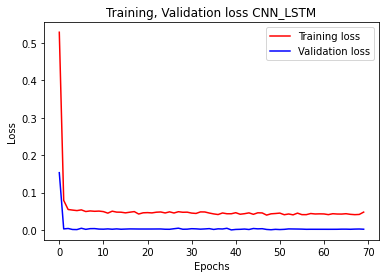

In [18]:
epochs = range(EPOCHS)
plt.plot(epochs, CNN_LSTM_train_losses, 'r', label='Training loss')
plt.plot(epochs, CNN_LSTM_validation_losses, 'b', label='Validation loss')
plt.title('Training, Validation loss CNN_LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# different train-validation loop for CNN_LSTM since we split the data to feed CNN and LSTM
model2 = standard_LSTM()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
loss_fn = torch.nn.MSELoss()
print(model2)

# train model2 and log train/validation losses
standard_LSTM_train_losses = []
standard_LSTM_validation_losses = []

# train-validation loop for standard_LSTM
for epoch in range(EPOCHS):
    batch_losses = []
    training_loss = 0.0
    #training loop
    for inputs, labels in train_loader:
        model2 = model2.train()
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = loss_fn(labels.float(), outputs)
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
    training_loss = np.mean(batch_losses)
    standard_LSTM_train_losses.append(training_loss)
    scheduler.step()
    
    #validation loop
    with torch.no_grad():
        val_losses = []
        validation_loss = 0.0
        for val_inputs, val_labels in val_loader:
            model2 = model2.eval()
            outputs_vl= model2(val_inputs)
            loss = loss_fn(outputs_vl, val_labels)
            val_losses.append(loss.item())
        
        validation_loss = np.mean(val_losses)
        standard_LSTM_validation_losses.append(validation_loss)

    print(f"[{epoch+1}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")
state_dict1= model2.state_dict()
#torch.save(model2.state_dict(), MODEL_PATH)

standard_LSTM(
  (relu): ReLU()
  (lstm): LSTM(1, 100)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=5700, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)
[1] Training loss: 0.0782	 Validation loss: 0.0025
[2] Training loss: 0.0380	 Validation loss: 0.0006
[3] Training loss: 0.0346	 Validation loss: 0.0015
[4] Training loss: 0.0333	 Validation loss: 0.0008
[5] Training loss: 0.0319	 Validation loss: 0.0090
[6] Training loss: 0.0320	 Validation loss: 0.0039
[7] Training loss: 0.0329	 Validation loss: 0.0006
[8] Training loss: 0.0304	 Validation loss: 0.0015
[9] Training loss: 0.0304	 Validation loss: 0.0000
[10] Training loss: 0.0297	 Validation loss: 0.0035
[11] Training loss: 0.0305	 Validation loss: 0.0041
[12] Training loss: 0.0269	 Validation loss: 0.0019
[13] Training loss: 0.0279	 Validation loss: 0.0002
[14] Training loss: 0.0260	 Validation loss: 0.0002
[15] Training loss: 0.0260	 Validation loss: 0.0017
[16] Trai

In [ ]:
# here call test for standard_LSTM
model2.load_state_dict(state_dict1)
standard_LSTM_test_losses = eval_model(test_loader, model2, nn.MSELoss())

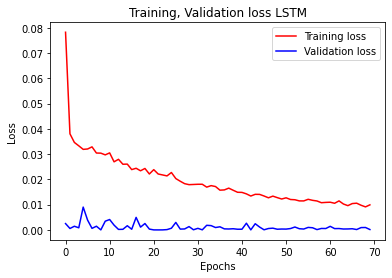

In [20]:
epochs = range(EPOCHS)
plt.plot(epochs, standard_LSTM_train_losses, 'r', label='Training loss')
plt.plot(epochs, standard_LSTM_validation_losses, 'b', label='Validation loss')
plt.title('Training, Validation loss LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()